In [1]:
from sqlalchemy import create_engine
import pandas as pd
import datetime

In [2]:
#see snagZips notebook in same repo to see how I did the google API portion
engine = create_engine("sqlite:///mta.db")
df = pd.read_sql("""SELECT * FROM mta_data;""",engine)
zipData=pd.read_sql("""SELECT z.STATION,z.CODE,CASE WHEN i.INCOME !='-' THEN i.INCOME ELSE 0 END AS 'INCOME' FROM zip_data z JOIN income_data i on z.CODE=i.CODE;""",engine)
zipData=zipData.set_index('STATION')
#CASE in order to handle some dirty data
#as a quick aside, unfortunately SQLite doesn't support a DATE datatype, in which case I would've pulled the years
#seperately as so:
#df[year] = pd.read_sql("""SELECT * FROM mta_data WHERE DATE BETWEEN '1/1/20[year]' AND '12/31/20[year]';""",engine)
#where year in (19,20)

,CODE,INCOME
STATION,,
59 ST,11234,85807
5 AV/59 ST,10022,150718
49 ST,10019,103792
TIMES SQ-42 ST,10018,122484
34 ST-HERALD SQ,10018,122484
...,...,...
TOMPKINSVILLE,10304,54199
RIT-MANHATTAN,10017,131045
RIT-ROOSEVELT,10065,148441


In [5]:
zipData.sample(5)

,STATION,CODE,INCOME
355,STERLING ST,11225,59820
240,14TH STREET,10011,138272
69,3 AV,10003,118161
238,CHRISTOPHER ST,10014,133501
226,NEPTUNE AV,11224,32549


In [6]:
df["DATE_TIME"]=pd.to_datetime(df.DATE+" "+df.TIME,format="%m/%d/%Y %H:%M:%S")

In [7]:
df.DESC.value_counts()

REGULAR       1852416
RECOVR AUD       7559
Name: DESC, dtype: int64

In [8]:
df.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [9]:
df.DESC.value_counts()

REGULAR       1852416
RECOVR AUD       7554
Name: DESC, dtype: int64

In [10]:
#okay now let's try splitting up between 2019 and 2020
mask1=(df.DATE_TIME >= datetime.datetime(2019,1,1)) & (df.DATE_TIME <= datetime.datetime(2019,12,31))
mask2=(df.DATE_TIME >= datetime.datetime(2020,1,1)) & (df.DATE_TIME <= datetime.datetime(2020,12,31))

In [11]:
df2019=df[mask1]
df2020=df[mask2]

In [12]:
#note that currently lose a couple of things including the time- will need to rectify that later
turnstiles_daily2019 = (df2019
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

turnstiles_daily2020=  (df2020
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [13]:
turnstiles_daily2019[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily2019
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))
turnstiles_daily2020[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily2020
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))

In [14]:
#drops the top row since not really calculable
turnstiles_daily2019.dropna(subset=["PREV_DATE"],axis=0,inplace=True)
turnstiles_daily2020.dropna(subset=["PREV_DATE"],axis=0,inplace=True)

In [15]:
#note the negative min value
#also note how much larger max is to 75%
(turnstiles_daily2019["ENTRIES"] - turnstiles_daily2019["PREV_ENTRIES"]).describe()

count    1.302340e+05
mean     4.081714e+04
std      9.727063e+06
min     -1.437241e+09
25%      2.640000e+02
50%      8.220000e+02
75%      1.608000e+03
max      2.055526e+09
dtype: float64

In [16]:
# How many rows are backwards
turnstiles_daily2019[turnstiles_daily2019["ENTRIES"] < turnstiles_daily2019["PREV_ENTRIES"]].shape

(1292, 8)

In [17]:
turnstiles_daily2019[turnstiles_daily2019["ENTRIES"] < turnstiles_daily2019["PREV_ENTRIES"]].head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
2153,A025,R023,01-03-01,34 ST-HERALD SQ,04/28/2019,1238466254,04/27/2019,1.238469e+09
2154,A025,R023,01-03-01,34 ST-HERALD SQ,04/29/2019,1238462681,04/28/2019,1.238466e+09
2155,A025,R023,01-03-01,34 ST-HERALD SQ,04/30/2019,1238458809,04/29/2019,1.238463e+09
2156,A025,R023,01-03-01,34 ST-HERALD SQ,05/01/2019,1238454628,04/30/2019,1.238459e+09
2157,A025,R023,01-03-01,34 ST-HERALD SQ,05/02/2019,1238450581,05/01/2019,1.238455e+09


In [18]:
#shamelessly stolen from pair problems
def dailyCounts(row,maxCounter):
    counter = row["ENTRIES"]-row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > maxCounter:
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > maxCounter:
        return 0
    return counter

In [19]:
turnstiles_daily2019["DAILY_ENTRIES2019"] = turnstiles_daily2019.apply(dailyCounts,axis=1,maxCounter=1000000)
turnstiles_daily2020["DAILY_ENTRIES2020"] = turnstiles_daily2020.apply(dailyCounts,axis=1,maxCounter=1000000)

entries: 142 <-- 1087600.0
entries: 769 <-- 15418705.0
entries: 1377 <-- 4767345.0
entries: 335092173 <-- 3421982.0
entries: 134 <-- 3072837.0
entries: 39 <-- 4605263.0
entries: 131075 <-- 2222463.0
entries: 2223006 <-- 131075.0
entries: 423 <-- 6527507.0
entries: 569320761 <-- 4807349.0
entries: 170 <-- 9029061.0
entries: 65536 <-- 839317244.0
entries: 184608339 <-- 746400.0
entries: 190 <-- 2898303.0
entries: 50 <-- 1544151.0
entries: 524 <-- 3911943.0
entries: 196614 <-- 2998634.0
entries: 326 <-- 3755677.0
entries: 735 <-- 2021820.0
entries: 2436 <-- 6998906.0
entries: 273 <-- 8876303.0
entries: 1178879221 <-- 4472670.0
entries: 6582 <-- 2204424.0
entries: 196626 <-- 68461837.0
entries: 146 <-- 36965539.0
entries: 907 <-- 2357444.0
entries: 12 <-- 4887261.0
entries: 767 <-- 9441238.0
entries: 1058618 <-- 102390450.0
entries: 2084 <-- 7603756.0
entries: 1198 <-- 1068342.0
entries: 148 <-- 6333363.0
entries: 30933984 <-- 6069289.0
entries: 115 <-- 12739117.0
entries: 1121 <-- 6546757

In [20]:
turnstiles_daily2019.sample(5)

,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES2019
23839,J002,R460,00-00-02,MARCY AV,04/28/2019,755800,04/27/2019,7.552920e+05,508.0
28120,N006A,R280,00-00-00,190 ST,05/06/2019,1442301222,05/05/2019,1.442303e+09,1990.0
49320,N220,R155,01-00-04,KINGSBRIDGE RD,05/17/2019,1369136,05/16/2019,1.368331e+06,805.0
127795,R604,R108,03-00-01,BOROUGH HALL,05/22/2019,9055110,05/21/2019,9.053456e+06,1654.0
18768,E014,R374,00-05-00,BAY PKWY,04/29/2019,150995769,04/28/2019,1.509958e+08,2.0


In [21]:
#anyways, moving on to the station level (more relevant in my case)
station_daily2019=turnstiles_daily2019.groupby(["STATION", "DATE"])[['DAILY_ENTRIES2019']].sum().reset_index()
station_daily2020=turnstiles_daily2020.groupby(["STATION", "DATE"])[['DAILY_ENTRIES2020']].sum().reset_index()
station_daily2019.head()

,STATION,DATE,DAILY_ENTRIES2019
0,1 AV,04/28/2019,5205.0
1,1 AV,04/29/2019,17134.0
2,1 AV,04/30/2019,18588.0
3,1 AV,05/01/2019,19221.0
4,1 AV,05/02/2019,19406.0


In [22]:
station_monthly2019=station_daily2019.groupby(['STATION']).sum()
station_monthly2020=station_daily2020.groupby(['STATION']).sum()

In [25]:
station_monthly2020.head()

,DAILY_ENTRIES2020
STATION,
1 AV,834493.0
103 ST,122328.0
103 ST-CORONA,118413.0
104 ST,22709.0
110 ST,52157.0


In [26]:
#now trying to merge the two dfs
combined_monthly=station_monthly2019.copy()
combined_monthly=combined_monthly.join(station_monthly2020)

In [27]:
combined_monthly.head(5)

,DAILY_ENTRIES2019,DAILY_ENTRIES2020
STATION,,
1 AV,423829.0,834493.0
103 ST,761177.0,122328.0
103 ST-CORONA,495322.0,118413.0
104 ST,110988.0,22709.0
110 ST,263133.0,52157.0


In [29]:
zipData=zipData.set_index('STATION')
zipData.head(5)

,CODE,INCOME
STATION,,
59 ST,11234,85807
5 AV/59 ST,10022,150718
49 ST,10019,103792
TIMES SQ-42 ST,10018,122484
34 ST-HERALD SQ,10018,122484


In [30]:
combined_monthly=combined_monthly.join(zipData)

In [31]:
combined_monthly.head()

,DAILY_ENTRIES2019,DAILY_ENTRIES2020,CODE,INCOME
STATION,,,,
1 AV,423829.0,834493.0,10009.0,63717
103 ST,761177.0,122328.0,10025.0,91624
103 ST-CORONA,495322.0,118413.0,11368.0,54211
104 ST,110988.0,22709.0,11418.0,68920
110 ST,263133.0,52157.0,10026.0,59691


In [32]:
combined_monthly["Percent Change"]=(combined_monthly["DAILY_ENTRIES2020"]-combined_monthly["DAILY_ENTRIES2019"])/combined_monthly["DAILY_ENTRIES2019"]

In [33]:
combined_monthly = combined_monthly.fillna(0)
combined_monthly = combined_monthly[~combined_monthly['INCOME'].isin(["-"])]
#dealing with dirty data from the zip_data table (prior to me realizing I could do via SQL)
combined_monthly.astype({'INCOME':'float64'})

,DAILY_ENTRIES2019,DAILY_ENTRIES2020,CODE,INCOME,Percent Change
STATION,,,,,
1 AV,423829.0,834493.0,10009.0,63717.0,0.968938
103 ST,761177.0,122328.0,10025.0,91624.0,-0.839291
103 ST-CORONA,495322.0,118413.0,11368.0,54211.0,-0.760937
104 ST,110988.0,22709.0,11418.0,68920.0,-0.795392
110 ST,263133.0,52157.0,10026.0,59691.0,-0.801785
...,...,...,...,...,...
WOODLAWN,170063.0,37713.0,10466.0,58393.0,-0.778241
WORLD TRADE CTR,431054.0,22642.0,10007.0,224063.0,-0.947473
WTC-CORTLANDT,308198.0,14423.0,10006.0,179044.0,-0.953202


In [148]:
#dropping a couple of outliers
outliersMask=combined_monthly["Percent Change"]>=1
combined_monthly.drop(combined_monthly[outliersMask].index,inplace=True)

In [68]:
zeroMask=combined_monthly["INCOME"]==0
combined_monthly.drop(combined_monthly[zeroMask].index,inplace=True)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

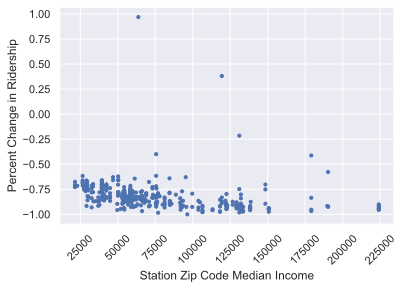

In [98]:
plt.scatter(combined_monthly["INCOME"].astype('int32'),combined_monthly["Percent Change"],s=10)
plt.xticks(rotation=45)
plt.xlabel("Station Zip Code Median Income")
plt.ylabel("Percent Change in Ridership")
sns.set_theme();

In [90]:
combined_noPos=combined_monthly.copy()
moreMask=combined_noPos["Percent Change"]>0
combined_noPos.drop(combined_noPos[moreMask].index,inplace=True)

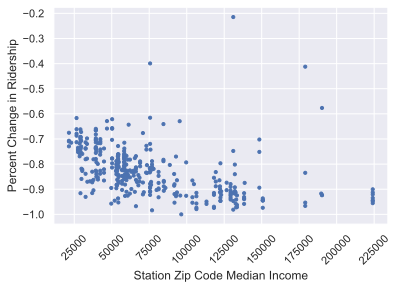

In [91]:
plt.scatter(combined_noPos["INCOME"].astype('int32'),combined_noPos["Percent Change"],s=10)
plt.xticks(rotation=45)
plt.xlabel("Station Zip Code Median Income")
plt.ylabel("Percent Change in Ridership")
sns.set_theme();

In [191]:
#quickly checking in on corr()
correlation=combined_monthly.copy()
correlation.INCOME=test["INCOME"].astype('int32')
correlation.corr()

,DAILY_ENTRIES2019,DAILY_ENTRIES2020,CODE,INCOME,Percent Change
DAILY_ENTRIES2019,1.000000,0.627306,-0.374559,0.350366,-0.164826
DAILY_ENTRIES2020,0.627306,1.000000,-0.181184,0.107574,0.484876
CODE,-0.374559,-0.181184,1.000000,-0.388579,0.116044
INCOME,0.350366,0.107574,-0.388579,1.000000,-0.271746
Percent Change,-0.164826,0.484876,0.116044,-0.271746,1.000000


In [100]:
#okay now moving on to standard difference in daily commutership for all stations (so grouping by date)
station_daily2019.head(5)
station_daily2020.head(5)

,STATION,DATE,DAILY_ENTRIES2019
0,1 AV,04/28/2019,5205.0
1,1 AV,04/29/2019,17134.0
2,1 AV,04/30/2019,18588.0
3,1 AV,05/01/2019,19221.0
4,1 AV,05/02/2019,19406.0


In [155]:
dailyTot2019=station_daily2019.groupby(["DATE"])[['DAILY_ENTRIES2019']].sum().reset_index()
dailyTot2020=station_daily2020.groupby(["DATE"])[['DAILY_ENTRIES2020']].sum().reset_index()
dailyTot2019["DATE_TIME"]=pd.to_datetime(dailyTot2019.DATE,format="%m/%d/%Y")
dailyTot2020["DATE_TIME"]=pd.to_datetime(dailyTot2020.DATE,format="%m/%d/%Y")
dailyTot2019["DAY"]=dailyTot2019["DATE_TIME"].dt.day.astype('int')
dailyTot2020["DAY"]=dailyTot2020["DATE_TIME"].dt.day.astype('int')
dailyTot2019.drop_duplicates(subset=["DAY"])

,DATE,DAILY_ENTRIES2019,DATE_TIME,DAY
0,04/28/2019,3007192.0,2019-04-28,28
1,04/29/2019,5994293.0,2019-04-29,29
2,04/30/2019,6728814.0,2019-04-30,30
3,05/01/2019,6695961.0,2019-05-01,1
4,05/02/2019,6656067.0,2019-05-02,2
5,05/03/2019,7205978.0,2019-05-03,3
6,05/04/2019,3606375.0,2019-05-04,4
7,05/05/2019,2623229.0,2019-05-05,5
8,05/06/2019,6788321.0,2019-05-06,6
9,05/07/2019,6149626.0,2019-05-07,7


In [156]:
#cleaning up areas in which the date range differs due to file cutoffs
dailyTot2019.drop([0,1,2],inplace=True)
dailyTot2019.head()

,DATE,DAILY_ENTRIES2019,DATE_TIME,DAY
3,05/01/2019,6695961.0,2019-05-01,1
4,05/02/2019,6656067.0,2019-05-02,2
5,05/03/2019,7205978.0,2019-05-03,3
6,05/04/2019,3606375.0,2019-05-04,4
7,05/05/2019,2623229.0,2019-05-05,5


In [159]:
dailyTot2020.drop([0,1,2,3,4],inplace=True)
dailyTot2020.head()

,DATE,DAILY_ENTRIES2020,DATE_TIME,DAY
5,05/01/2020,528806.0,2020-05-01,1
6,05/02/2020,360455.0,2020-05-02,2
7,05/03/2020,366922.0,2020-05-03,3
8,05/04/2020,1210867.0,2020-05-04,4
9,05/05/2020,557107.0,2020-05-05,5


In [164]:
dailyTot2020.drop([29,30,31,32,33],inplace=True)
dailyTot2020.tail()

,DATE,DAILY_ENTRIES2020,DATE_TIME,DAY
24,05/20/2020,726379.0,2020-05-20,20
25,05/21/2020,667780.0,2020-05-21,21
26,05/22/2020,673296.0,2020-05-22,22
27,05/23/2020,981559.0,2020-05-23,23
28,05/24/2020,537275.0,2020-05-24,24


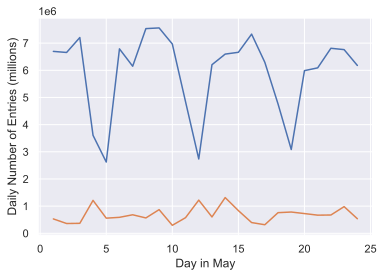

In [169]:
plt.plot(dailyTot2019["DAY"],dailyTot2019["DAILY_ENTRIES2019"],label="2019")
plt.plot(dailyTot2020["DAY"],dailyTot2020["DAILY_ENTRIES2020"],label="2020")
plt.ylabel("Daily Number of Entries (millions)")
plt.xlabel("Day in May")
sns.set_theme()
plt.show();

In [179]:
#quickly recalculating previous DFs in order to look at stations with a positive increase in ridership
combined_monthly2=station_monthly2019.copy()
combined_monthly2=combined_monthly2.join(station_monthly2020)
combined_monthly2["Percent Change"]=(combined_monthly2["DAILY_ENTRIES2020"]-combined_monthly2["DAILY_ENTRIES2019"])/combined_monthly2["DAILY_ENTRIES2019"]

In [174]:
combined_monthly2.head()

,DAILY_ENTRIES2019,DAILY_ENTRIES2020,Percent Change
STATION,,,
1 AV,423829.0,834493.0,0.968938
103 ST,761177.0,122328.0,-0.839291
103 ST-CORONA,495322.0,118413.0,-0.760937
104 ST,110988.0,22709.0,-0.795392
110 ST,263133.0,52157.0,-0.801785


In [173]:
combined_monthly2["Percent Change"]=(combined_monthly2["DAILY_ENTRIES2020"]-combined_monthly2["DAILY_ENTRIES2019"])/combined_monthly2["DAILY_ENTRIES2019"]

In [180]:
outliersMask=combined_monthly2["Percent Change"]<=0
combined_monthly2.drop(combined_monthly2[outliersMask].index,inplace=True)

In [181]:
combined_monthly2.head()

,DAILY_ENTRIES2019,DAILY_ENTRIES2020,Percent Change
STATION,,,
1 AV,423829.0,834493.0,0.968938
81 ST-MUSEUM,349393.0,1303436.0,2.730573
DEKALB AV,814942.0,1124733.0,0.380139
EUCLID AV,287497.0,660318.0,1.296782
